In [ ]:
!pip install 'imutils'


# importing all the required library and defining all funtions

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imutils import paths
import cv2
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
plt.style.use('ggplot')


# initailize values
data_dir = "./input_data/"
INIT_LR = 1e-3
#0.001
EPOCHS = 100
BS = 64
momentum=0.9
opt = SGD(lr=INIT_LR, momentum=momentum)

# load data
def load_data(data_dir):
    data_dir = pathlib.Path(data_dir)
    imagePaths = list(paths.list_images(data_dir))
    data = []
    targets = []

    for each_imagePath in imagePaths:
        label = each_imagePath.split(os.path.sep)[-2]

        image = cv2.imread(each_imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if label == 'covid19':
            hflipped_image = np.fliplr(image)
            vflipped_image = np.flipud(image)
            data.append(hflipped_image)
            targets.append(label)
            data.append(vflipped_image)
            targets.append(label)
        data.append(image)
        targets.append(label)
    return data, targets


# normalize data
def normalize_data(data, targets):
    X = np.array(data).astype('float32') / 255.0
    y = np.array(targets)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = to_categorical(y)
    target_names = label_encoder.inverse_transform(np.arange(3))

    return X, y, target_names


def define_model_1vgg():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


# define cnn model
def define_model_2vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


# define cnn model
def define_model_3vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                     input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


def vgg16_with_feature_extraction():
    headModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    tailModel = headModel.output
    tailModel = Flatten(name="flatten")(tailModel)
    tailModel = Dense(128, activation="relu")(tailModel)
    tailModel = BatchNormalization()(tailModel)
    tailModel = Dropout(0.5)(tailModel)
    tailModel = Dense(3, activation="softmax")(tailModel)
    model = Model(inputs=headModel.input, outputs=tailModel)
    for layer in headModel.layers:
        layer.trainable = False
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()

    return model


def vgg16_with_fineTuning():

    headModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    tailModel = headModel.output
    tailModel = Flatten(name="flatten")(tailModel)
    tailModel = Dense(128, activation="relu")(tailModel)
    tailModel = BatchNormalization()(tailModel)
    tailModel = Dropout(0.5)(tailModel)
    tailModel = Dense(3, activation="softmax")(tailModel)
    model = Model(inputs=headModel.input, outputs=tailModel)
    headModel.trainable = True
    set_trainable = False
    for layer in headModel.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()
    return model


# Model accuracy and loss with train and validation set
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


def evaluate_model(model, testX, testY, target_names):
    print("[INFO] evaluating network on Test set...")
    predIdxs = model.predict(testX, batch_size=BS)
    predIdxs = np.argmax(predIdxs, axis=1)
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(norm_cm, index = target_names, columns = target_names)
    print("Confusion Marix")
    plt.figure(figsize=(10,7))
    sn.heatmap(df_cm, annot=True,  linewidths=.5)
    print('Accuracy Score :',accuracy_score(testY.argmax(axis=1), predIdxs))
    print('Classification Report : ')
    print(classification_report(testY.argmax(axis=1), predIdxs))


# data load and split

In [3]:
data, targets = load_data(data_dir)
X, y, target_names = normalize_data(data, targets)
# train validation and test set
trainX, testX, trainY, testY = train_test_split(X, y, stratify=y, test_size=0.20, random_state=19)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, test_size=0.20, random_state=19)

print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Validation: X=%s, y=%s' % (valX.shape, valY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

[INFO] loading images...
##########################################################
Train: X=(904, 224, 224, 3), y=(904, 3)
Validation: X=(226, 224, 224, 3), y=(226, 3)
Test: X=(283, 224, 224, 3), y=(283, 3)


# Simple CNN model

In [10]:
# 3VGG

model_3vgg = define_model_3vgg() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)     

In [11]:
history_3vgg = model_3vgg.fit(trainX, trainY, epochs=EPOCHS, batch_size=BS, validation_data=(valX, valY), verbose=2)


Train on 904 samples, validate on 226 samples
Epoch 1/100
904/904 - 5s - loss: 0.6573 - accuracy: 0.7799 - val_loss: 3.8935 - val_accuracy: 0.4513
Epoch 2/100
904/904 - 3s - loss: 0.1510 - accuracy: 0.9480 - val_loss: 2.5184 - val_accuracy: 0.2876
Epoch 3/100
904/904 - 3s - loss: 0.1250 - accuracy: 0.9558 - val_loss: 1.5096 - val_accuracy: 0.3451
Epoch 4/100
904/904 - 3s - loss: 0.1082 - accuracy: 0.9635 - val_loss: 1.2846 - val_accuracy: 0.3761
Epoch 5/100
904/904 - 3s - loss: 0.1003 - accuracy: 0.9690 - val_loss: 1.5771 - val_accuracy: 0.3628
Epoch 6/100
904/904 - 3s - loss: 0.0895 - accuracy: 0.9679 - val_loss: 1.9029 - val_accuracy: 0.3496
Epoch 7/100
904/904 - 3s - loss: 0.0823 - accuracy: 0.9768 - val_loss: 2.1731 - val_accuracy: 0.3540
Epoch 8/100
904/904 - 3s - loss: 0.0635 - accuracy: 0.9779 - val_loss: 2.5782 - val_accuracy: 0.3540
Epoch 9/100
904/904 - 3s - loss: 0.0593 - accuracy: 0.9801 - val_loss: 2.6945 - val_accuracy: 0.3540
Epoch 10/100
904/904 - 3s - loss: 0.0463 - ac

Epoch 81/100
904/904 - 3s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4029 - val_accuracy: 0.8496
Epoch 82/100
904/904 - 3s - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.3377 - val_accuracy: 0.8628
Epoch 83/100
904/904 - 3s - loss: 0.0100 - accuracy: 0.9989 - val_loss: 0.1629 - val_accuracy: 0.9292
Epoch 84/100
904/904 - 3s - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9071
Epoch 85/100
904/904 - 3s - loss: 0.0105 - accuracy: 0.9989 - val_loss: 0.2629 - val_accuracy: 0.8938
Epoch 86/100
904/904 - 3s - loss: 0.0078 - accuracy: 0.9989 - val_loss: 0.2317 - val_accuracy: 0.9248
Epoch 87/100
904/904 - 3s - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.2037 - val_accuracy: 0.9248
Epoch 88/100
904/904 - 3s - loss: 0.0167 - accuracy: 0.9967 - val_loss: 0.1499 - val_accuracy: 0.9425
Epoch 89/100
904/904 - 3s - loss: 0.0247 - accuracy: 0.9912 - val_loss: 0.2120 - val_accuracy: 0.9248
Epoch 90/100
904/904 - 3s - loss: 0.0232 - accuracy: 0.9934 - val_loss: 0.2008 - v

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:249: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:256: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


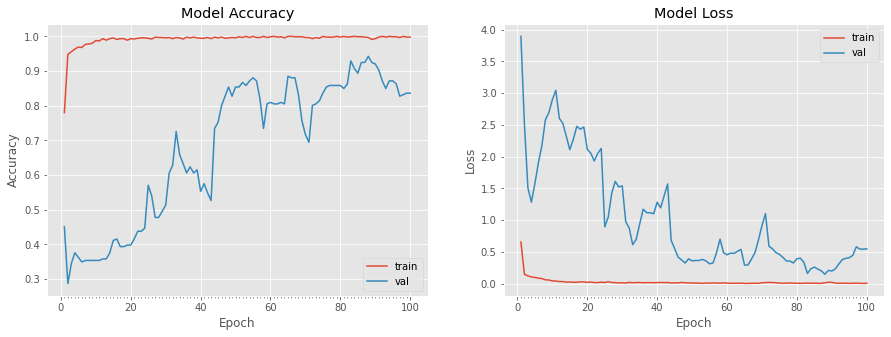

[INFO] evaluating network on Test set...
Confusion Marix
Accuracy Score : 0.8162544169611308
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        83
           1       1.00      0.68      0.81       100
           2       0.66      1.00      0.79       100

    accuracy                           0.82       283
   macro avg       0.89      0.81      0.82       283
weighted avg       0.88      0.82      0.82       283



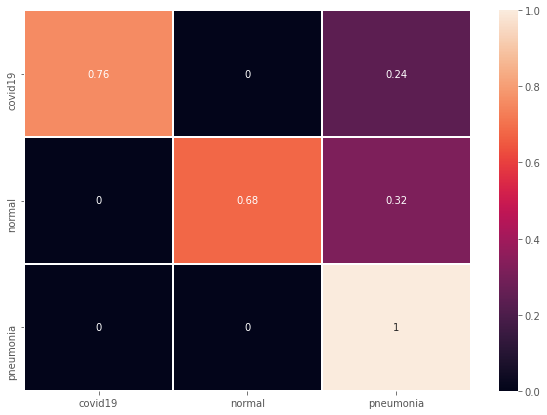

In [12]:
plot_model_history(history_3vgg)
evaluate_model(model_3vgg, testX, testY, target_names)